# Notebook 021: Baseline Classifier Model

This notebook contains a baseline crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class Logistic Regression Models with and without regularization.

In [30]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
MODEL_ROOT = '../models'
FIGURES_ROOT = '../figures/model-baseline'
WRITEDIR_ROOT = '../models/baseline'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
FEATURES_ROOT = os.path.join(DATA_ROOT, 'processed')

readfile_model = os.path.join(READDIR_ROOT, 'crime-model-data-v1.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

readfile_feat_property = os.path.join(FEATURES_ROOT, 'property-assessment-features-2013-2019.csv')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}'.format(
        readfile_model, readfile_feat_property, readfile_tractshapes, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/crime-model-data-v1.csv
	../data/processed/property-assessment-features-2013-2019.csv
	../data/raw/shapefile/census-tracts/Census_2010_Tracts.shp
	../models/baseline


In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

In [4]:
# read in model data
df = pd.read_csv(readfile_model)

In [5]:
# drop rows with null predictor values
# This missing data will need to be dealt with in a later version of this model
dropna_cols = [
    'commercial-mix-ratio',
    'industrial-mix-ratio',
    'owner-occupied-ratio',
    'residential-median-value',
    'residential-gini-coef',
    'industrial-mix-ratio-3yr-cagr',
    'commercial-mix-ratio-3yr-cagr',
    'owner-occupied-ratio-3yr-cagr',
    'residential-median-value-3yr-cagr',
    'residential-gini-coef-3yr-cagr',
]

df = df.dropna(subset=dropna_cols)

In [6]:
# print summary info on this model data
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149203 entries, 0 to 151071
Data columns (total 29 columns):
crime-type                           149203 non-null object
INCIDENT_NUMBER                      149203 non-null object
OFFENSE_DESCRIPTION                  149203 non-null object
timestamp                            149203 non-null object
lat                                  149203 non-null float64
lon                                  149203 non-null float64
year                                 149203 non-null int64
month                                149203 non-null int64
day-of-week                          149203 non-null object
hour                                 149203 non-null int64
ZIP5                                 149177 non-null float64
ZIP5_area                            149177 non-null float64
Name                                 149135 non-null object
Neighborhood_area                    149135 non-null float64
Neighborhood_area_2                  149135 non

,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,commercial-mix-ratio,industrial-mix-ratio,owner-occupied-ratio,residential-median-value,residential-gini-coef,industrial-mix-ratio-3yr-cagr,commercial-mix-ratio-3yr-cagr,owner-occupied-ratio-3yr-cagr,residential-median-value-3yr-cagr,residential-gini-coef-3yr-cagr
0,fraud,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,8,Thursday,17,...,0.000000,0.000294,0.000000,756500.0,0.000000,-0.034814,0.000000,0.000000,0.024264,0.000000
1,harassment-disturbance,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,6,Wednesday,21,...,0.069416,0.000000,0.550355,745950.0,0.199606,0.000000,-0.010424,-0.028224,0.068142,0.011166
2,theft,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,3,Sunday,8,...,0.478130,0.000938,0.456287,538500.0,0.228793,-0.084828,0.010549,-0.014131,0.060340,0.018436
4,theft,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,4,Saturday,8,...,0.375058,0.076862,0.460751,355500.0,0.172898,0.060168,-0.007779,-0.023444,0.082123,0.025972
5,theft,I192077992,auto theft - leased/rented vehicle,2019-07-16 08:00:00,42.328564,-71.068353,2019,7,Tuesday,8,...,0.375058,0.076862,0.460751,355500.0,0.172898,0.060168,-0.007779,-0.023444,0.082123,0.025972


## Preprocess data prior to splitting into train-test sets

In [7]:
# print summary value counts for comparison after mapping values
print(df['day-of-week'].value_counts(dropna=False))
print()
print(df['month'].value_counts(dropna=False))
print()
print(df['crime-type'].value_counts(dropna=False).sort_index())
print()

Friday       22445
Wednesday    21864
Thursday     21671
Saturday     21402
Monday       21350
Tuesday      21211
Sunday       19260
Name: day-of-week, dtype: int64

8     14823
7     14637
6     14370
5     14246
1     13250
4     13195
3     12878
2     11704
10    10509
9     10451
11     9654
12     9486
Name: month, dtype: int64

burglary                   6583
drugs-substances          15134
fraud                     11163
harassment-disturbance    24084
other                      7385
robbery                    3949
theft                     40204
vandalism-property        15956
violence-aggression       24745
Name: crime-type, dtype: int64



In [8]:
# create dictionaries required for one-hot-encoding
# and mapping categorical values
months_dict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}

# assign numeric categories to our response variable categories
crime_type_dict = {
    'other': 0,
    'burglary': 1,
    'drugs-substances': 2,
    'fraud': 3,
    'harassment-disturbance': 4,
    'robbery': 5,
    'theft': 6,
    'vandalism-property': 7,
    'violence-aggression': 8,
}

###################################################
## MAP MONTHS DATA AND RESPONSE VARIABLE CATEGORIES
###################################################

df['month'] = df['month'].copy().map(months_dict)
df['crime-type'] = df['crime-type'].copy().map(crime_type_dict)

# print mapping results
print(df['month'].value_counts(dropna=False))
print()
print(df['crime-type'].value_counts(dropna=False).sort_index())
print()

Aug    14823
Jul    14637
Jun    14370
May    14246
Jan    13250
Apr    13195
Mar    12878
Feb    11704
Oct    10509
Sep    10451
Nov     9654
Dec     9486
Name: month, dtype: int64

0     7385
1     6583
2    15134
3    11163
4    24084
5     3949
6    40204
7    15956
8    24745
Name: crime-type, dtype: int64



In [9]:
# define order for sorting month columns once they are one-hot-encoded
months_col_order = list(months_dict.values())[1:]

# define order for sorting one-hot-encoded weekday columns
weekdays_list = [
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
]

# one-hot-encode categorical predictors day of week and month
weekday_dummies_df = pd.get_dummies(df['day-of-week']).drop(columns='Monday')[weekdays_list]
month_dummies_df = pd.get_dummies(df['month']).drop(columns='Jan')[months_col_order]

# append dummy columns to full dataframe in desired order
df[weekdays_list] = weekday_dummies_df[weekdays_list]
df[months_col_order] = month_dummies_df[months_col_order]

In [10]:
# generate "night" indicator for observations occuring between 8pm and 4am
# the next version of this model will use actual sunset/sunrise times for
# defining this variable
df['night'] = ((df['hour'] <4) | (df['hour']>20)).values.astype(int)

# print summary results of "night" feature creation to confirm results
print(df['hour'].value_counts().sort_index())
print()
print(df['night'].value_counts().sort_index())

0      8122
1      4308
2      3555
3      2060
4      1544
5      1379
6      1927
7      3308
8      5020
9      5725
10     6850
11     7237
12     8879
13     7841
14     8168
15     8045
16     9549
17    10076
18    10177
19     8850
20     7924
21     6991
22     6315
23     5353
Name: hour, dtype: int64

0    112499
1     36704
Name: night, dtype: int64


In [11]:
# print summary info to confirm resulting dataframe
# print summary info on this model data
print(df.columns)
df.head()

Index(['crime-type', 'INCIDENT_NUMBER', 'OFFENSE_DESCRIPTION', 'timestamp',
       'lat', 'lon', 'year', 'month', 'day-of-week', 'hour', 'ZIP5',
       'ZIP5_area', 'Name', 'Neighborhood_area', 'Neighborhood_area_2',
       'TRACTCE10', 'TRACTCE10_area', 'TRACTCE10_area_2', 'tract-match-key',
       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'],
      dtype='object')


,crime-type,INCIDENT_NUMBER,OFFENSE_DESCRIPTION,timestamp,lat,lon,year,month,day-of-week,hour,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,night
0,3,I192078177,forgery / counterfeiting,2019-08-01 17:46:00,42.304922,-71.102981,2019,Aug,Thursday,17,...,0,0,0,0,1,0,0,0,0,0
1,4,I192078061,harassment,2019-06-12 21:00:00,42.355553,-71.152747,2019,Jun,Wednesday,21,...,0,0,1,0,0,0,0,0,0,1
2,6,I192078038,larceny theft of mv parts & accessories,2019-03-10 08:00:00,42.345625,-71.041291,2019,Mar,Sunday,8,...,0,0,0,0,0,0,0,0,0,0
4,6,I192077997,auto theft - leased/rented vehicle,2019-04-13 08:00:00,42.328564,-71.068353,2019,Apr,Saturday,8,...,1,0,0,0,0,0,0,0,0,0
5,6,I192077992,auto theft - leased/rented vehicle,2019-07-16 08:00:00,42.328564,-71.068353,2019,Jul,Tuesday,8,...,0,0,0,1,0,0,0,0,0,0


## Execute train-test-split

In [12]:
#########################################
## GENERATE SPLITS
#########################################
np.random.seed(10)

X_train_labels, X_test_labels, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'crime-type'], 
    df['crime-type'],
    test_size=0.2,
    random_state = 109, 
    stratify = df['crime-type']
)

print(X_train_labels.shape)
print(X_test_labels.shape)
print(y_train.shape)
print(y_test.shape)

(119362, 46)
(29841, 46)
(119362,)
(29841,)


In [14]:
# specify 'label' columns to drop before running our baseline model
drop_cols = [
    'INCIDENT_NUMBER',
    'OFFENSE_DESCRIPTION',
    'timestamp',
    'lat',
    'lon',
    'year',
    'hour',
    'month',
    'day-of-week',
    'ZIP5',
    'ZIP5_area',
    'Name',
    'Neighborhood_area',
    'Neighborhood_area_2',
    'TRACTCE10',
    'TRACTCE10_area',
    'TRACTCE10_area_2',
    'tract-match-key',
]

# drop those columns
X_train = X_train_labels.drop(columns=drop_cols)
X_test = X_test_labels.drop(columns=drop_cols)

# print resulting dataframe results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(119362, 28)
(29841, 28)
(119362,)
(29841,)


In [15]:
# check resulting X_train dataframe info
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119362 entries, 131812 to 94612
Data columns (total 28 columns):
commercial-mix-ratio                 119362 non-null float64
industrial-mix-ratio                 119362 non-null float64
owner-occupied-ratio                 119362 non-null float64
residential-median-value             119362 non-null float64
residential-gini-coef                119362 non-null float64
industrial-mix-ratio-3yr-cagr        119362 non-null float64
commercial-mix-ratio-3yr-cagr        119362 non-null float64
owner-occupied-ratio-3yr-cagr        119362 non-null float64
residential-median-value-3yr-cagr    119362 non-null float64
residential-gini-coef-3yr-cagr       119362 non-null float64
Tuesday                              119362 non-null uint8
Wednesday                            119362 non-null uint8
Thursday                             119362 non-null uint8
Friday                               119362 non-null uint8
Saturday                             11

## Inspect multi-collinearity of predictors

Any collinearity will need to be dealt with in a later version of the model

In [27]:
def sort_pairwise_correlation(X_train):
    """
    Calculates a correlation matrix of all input predictors and observations,
    via the X_train dataframe, then returns a sorted dataframe of all
    pairwise correlation values (duplicates and same-value pairings removed).
    
    The returned sorted correlation summary dataframe is sorted in descending
    order, from highest to lowest correlation pairings.
    """
    # calculate correlation among all predictors
    correlation_matrix_df = X_train.corr()
    correlation_abs_matrix_df = X_train.corr().abs()

    # identify variables most heavily correlated in descending order
    # and remove pairwise groupings of the same predictors
    corr_unstack = correlation_abs_matrix_df.unstack()
    corr_sorted = corr_unstack.sort_values(ascending=False)
    corr_sorted = corr_sorted[corr_sorted < 1][::2]
    
    return corr_sorted


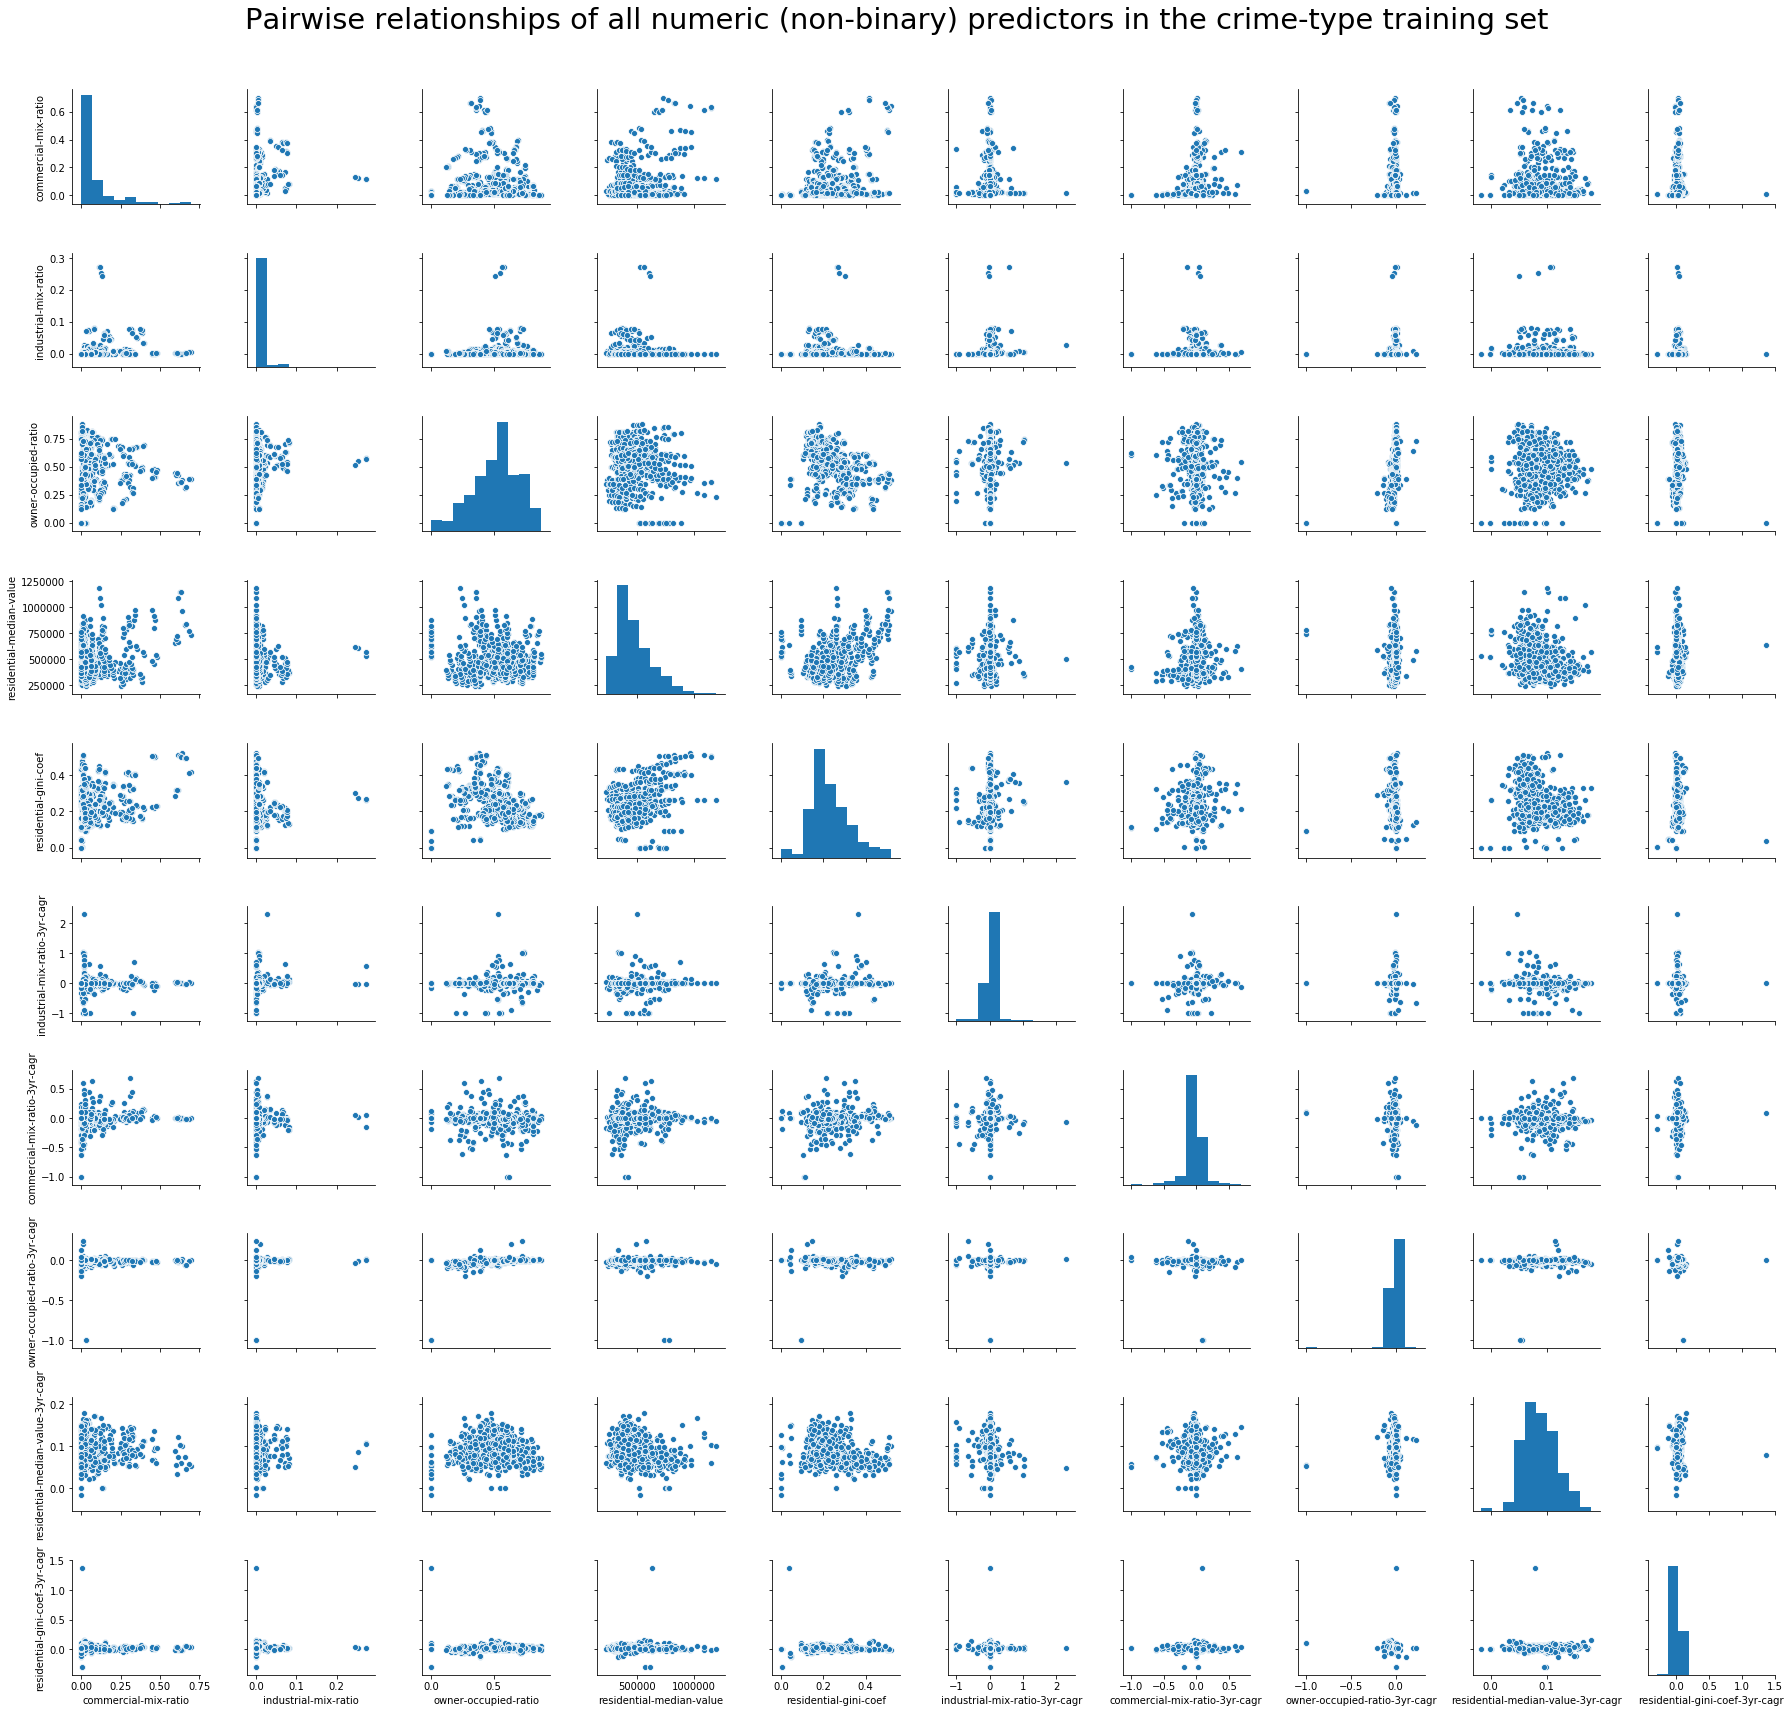

CPU times: user 26.6 s, sys: 20 ms, total: 26.6 s
Wall time: 26.6 s


In [38]:
%%time

savefig = True

# add tract-year match ids to identify unique numeric values in predictors
X_train_labels['tract_match_id'] = X_train_labels['TRACTCE10'].astype(str) + X_train_labels['year'].astype(str) 

# create dataframe of unique values
unique_values_df = X_train_labels.groupby('tract_match_id').agg(
    {
        'commercial-mix-ratio': 'first',
        'industrial-mix-ratio': 'first',
        'owner-occupied-ratio': 'first',
        'residential-median-value': 'first',
        'residential-gini-coef': 'first',
        'industrial-mix-ratio-3yr-cagr': 'first',
        'commercial-mix-ratio-3yr-cagr': 'first',
        'owner-occupied-ratio-3yr-cagr': 'first',
        'residential-median-value-3yr-cagr': 'first',
        'residential-gini-coef-3yr-cagr': 'first'
    }
)

# plot a scatter matrix of unique values for each predictor
sns.pairplot(unique_values_df)
plt.suptitle(
    'Pairwise relationships of all numeric (non-binary) predictors in the crime-type training set',
    fontsize=29
)
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'correlation-scatter-matrix-non-binary-predictors.png'))
plt.show();

In [41]:
#############################################
## Calculate and report on pairwise correlations
#############################################

# generate sorted correlation dataframe
corr_df = sort_pairwise_correlation(X_train)

# set corr threshold for reporting
corr_thresh = 0.20

print(
    '\nThe most strongly correlated predictors (corr > {0:.2f}) in our baseline model '\
    'predictor set and their corresponding correlation values are:\n\n{1}\n'.format(
        corr_thresh,
        corr_df[corr_df > corr_thresh],
    )
)


The most strongly correlated predictors (corr > 0.20) in our baseline model predictor set and their corresponding correlation values are:

residential-median-value           residential-gini-coef                0.683821
                                   commercial-mix-ratio                 0.577223
commercial-mix-ratio               residential-gini-coef                0.568382
owner-occupied-ratio               residential-gini-coef                0.416406
                                   owner-occupied-ratio-3yr-cagr        0.409340
residential-gini-coef              residential-median-value-3yr-cagr    0.342873
owner-occupied-ratio               commercial-mix-ratio                 0.314995
residential-median-value           residential-median-value-3yr-cagr    0.284154
                                   owner-occupied-ratio                 0.266935
owner-occupied-ratio-3yr-cagr      residential-gini-coef                0.262730
residential-median-value-3yr-cagr  commercial-mix-

## Create second version of X_train, X_test model data with standardized continuous numeric variables for comparison when running model

In [16]:
def standardize_features(train_df, val_df, exclude_scale_cols):
    """
    Scales val_df features based on train_df mean and std for each feature
    and returns the scaled dataframe. To specify features not to scale,
    use the exclude_scale_cols parameter
    
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param exclude_scale_cols: Optional list containing names of columns we
                               do not wish to scale
    :return: a feature-scaled version of the val_df dataframe
    """
    # create list of non-binary column names for scaling
    scaled_columns = train_df.columns.difference(exclude_scale_cols)
    
    # create StandardScaler instance fitted on non-binary train data
    Scaler = StandardScaler().fit(
        train_df[scaled_columns]
    )
    
    # scale val_df and convert to dataframe with column names
    scaled_df = pd.DataFrame(
        Scaler.transform(val_df[scaled_columns]),
        columns=scaled_columns,
    )
    
    # return full dataframe containing scaled_df merged with
    # original unscaled binary columns
    return pd.concat(
        [
            val_df.drop(scaled_columns, axis=1).reset_index(drop=True),
            scaled_df
        ],
        axis=1,
    )

In [17]:
# define binary columns to ensure those data points do not get standardized
binary_cols = [
    *weekdays_list,
    *months_col_order,
    'night'
]

# Perform standard scaling on both X_train and X_test data, fitting X_train as the
# scaler for both
X_train_scaled = standardize_features(
    X_train, X_train,
    exclude_scale_cols=binary_cols)

X_test_scaled = standardize_features(
    X_train, X_test,
    exclude_scale_cols=binary_cols)

## MODEL 1: Fit a multi-class multiple Logistic regression model first to the un-scaled data and inspect results

In [19]:
%%time

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit OVR model on unscaled features
multi_class='ovr'

OVRLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train, y_train)

print(OVRLogModel)
print()
print(
    'The resulting training and test accuracy scores for the unscaled OVR model are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        OVRLogModel.score(X_train, y_train),
        OVRLogModel.score(X_test, y_test)
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the unscaled OVR model are:

Training	0.2695
TEST		0.2695

CPU times: user 5.25 s, sys: 31.3 ms, total: 5.28 s
Wall time: 1.32 s


In [20]:
%%time

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train, y_train)

print(MNLogModel)
print()
print(
    'The resulting training and test accuracy scores for the unscaled Multinomial model are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        MNLogModel.score(X_train, y_train),
        MNLogModel.score(X_test, y_test)
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the unscaled Multinomial model are:

Training	0.2695
TEST		0.2695

CPU times: user 3.16 s, sys: 27.6 ms, total: 3.19 s
Wall time: 799 ms


## MODEL 2: Fit a multi-class multiple Logistic regression model first to the SCALED data and inspect results

In [22]:
%%time

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit OVR model on the scaled features
multi_class='ovr'

ScaledOVRLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train_scaled, y_train)

print(ScaledOVRLogModel)
print()
print(
    'The resulting training and test accuracy scores for the SCALED OVR model are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        ScaledOVRLogModel.score(X_train_scaled, y_train),
        ScaledOVRLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the SCALED OVR model are:

Training	0.2732
TEST		0.2725

CPU times: user 13.5 s, sys: 160 ms, total: 13.7 s
Wall time: 3.42 s


In [23]:
# fit OVR model on the scaled features
multi_class = 'multinomial'

ScaledMNLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train_scaled, y_train)

print(ScaledMNLogModel)
print()
print(
    'The resulting training and test accuracy scores for the SCALED Multinomial model are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        ScaledMNLogModel.score(X_train_scaled, y_train),
        ScaledMNLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the SCALED Multinomial model are:

Training	0.2734
TEST		0.2729



## MODEL 3: Fit a multi-class multiple Logistic regression model with LASSO (L1) regularization to the SCALED data and inspect results

In [25]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='ovr'

LassoScaledOVRLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledOVRLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized OVR model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledOVRLogModel.score(X_train_scaled, y_train),
        LassoScaledOVRLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized OVR model using the scaled data are:

Training	0.2732
TEST		0.2726

CPU times: user 31.4 s, sys: 3.79 ms, total: 31.4 s
Wall time: 30.7 s


In [26]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='multinomial'

LassoScaledMNLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledMNLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized Multinomial model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledMNLogModel.score(X_train_scaled, y_train),
        LassoScaledMNLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized Multinomial model using the scaled data are:

Training	0.2733
TEST		0.2730

CPU times: user 1min 13s, sys: 39.6 ms, total: 1min 13s
Wall time: 1min 13s


## Plot coefficients for Lasso Multinomial Logistic Regression

In [44]:
LassoScaledMNLogModel.coef_

array([[-2.33277067e-02,  1.46111974e-01,  1.96147046e-01,
         1.39877092e-01,  1.74604969e-01,  1.99034694e-02,
         1.17744635e-01,  1.90031516e-01,  1.28190748e-01,
         2.25816609e-02,  6.62964401e-03,  7.56100717e-02,
        -1.53606465e-02,  0.00000000e+00,  1.83041360e-02,
        -9.46410284e-02, -1.15526858e-01,  5.64598915e-01,
         5.78523352e-03, -2.90467589e-02, -6.67892101e-03,
        -1.60602787e-02,  0.00000000e+00,  3.20476223e-03,
         2.74644434e-02,  2.96931394e-03, -3.41215681e-02,
        -1.51932215e-02],
       [-5.11250034e-02, -2.06773292e-02, -1.09378499e-01,
         3.65852156e-03, -1.28692131e-01, -2.06577021e-01,
        -2.46507783e-02, -9.88230146e-02, -9.62718693e-02,
        -6.63255451e-03,  0.00000000e+00, -2.59551469e-02,
        -3.18350425e-02,  4.05919151e-02, -1.18711228e-02,
        -4.23975171e-02,  0.00000000e+00, -8.15400514e-02,
         2.88208126e-02, -1.09824590e-02,  1.23804797e-02,
        -9.27272524e-03,  2.77